# Cleaning the newspaper archive

In [1]:
import os
import re
import json
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial
from itertools import product
from collections import Counter
from unicodedata import category
from multiprocessing import cpu_count
from utils import multicore_apply

import fasttext
from umap import UMAP
from scipy.linalg import norm
from reo_toolkit import is_maori
from gensim.models import Phrases
from nltk.tokenize import word_tokenize, sent_tokenize

import warnings
from numba.errors import NumbaWarning
warnings.filterwarnings("ignore", category = UserWarning)
warnings.simplefilter("ignore", category = NumbaWarning)

In [2]:
def remove_punctuation(text):
    return ''.join(ch for ch in text if category(ch)[0] != 'P')
    
def normalize_text(text):
    text = re.sub("\s{2,}", " ", text)
    return remove_punctuation(text.lower())

## Cleaning the text

In [3]:
with open('../data/output.json', 'r') as f:
    papers = pd.DataFrame(json.load(f))

In [4]:
col_patterns = {
    'newspaper_id': '([A-Z]+)[^/]+$',
    'year': '[A-Z]+([0-9]{4})[^/]+$',
    'month': '[A-Z]+[0-9]{4}([0-9]{2})[^/]+$',
    'day': '[A-Z]+[0-9]{6}([0-9]{2})[^/]+$',
    'id': '[A-Z]+[0-9]+\.([^/]+)$'
}

for col, pattern in col_patterns.items():
    papers[col] = papers.url.str.extract(pattern)

papers.head()

,url,text,newspaper_id,year,month,day,id
0,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,AMW,1848,10,19,2.14.1
1,https://paperspast.natlib.govt.nz/newspapers/A...,E taia ana te Kai-mataara o nga iwi erua hei n...,AMW,1848,10,19,2.13
2,https://paperspast.natlib.govt.nz/newspapers/H...,"UNKNOWN\nKlte kaite ote Hokioi tena koe, mete ...",HOKIOI,1862,11,10,2.3
3,https://paperspast.natlib.govt.nz/newspapers/H...,"Kotikoti ki, Kotikoti korero.\nIte Tau 1856 ka...",HOKIOI,1862,12,08,2.3
4,https://paperspast.natlib.govt.nz/newspapers/H...,"Te Kawakaw, wahi o Wharekahika. Hanueri 2 1859...",HOKIOI,1862,06,15,2.6


In [5]:
papers['paragraph'] = papers.text.apply(lambda s: s.split("\n"))
papers = papers.explode('paragraph')

In [6]:
%%time
papers['sentence'] = multicore_apply(papers.paragraph, sent_tokenize)
papers = papers.explode('sentence')
papers = papers[~papers.sentence.isna()]

papers.head()

100%|██████████| 94.3k/94.3k [00:00<00:00, 253kit/s]  
94346it [00:00, 505226.73it/s]


CPU times: user 21.3 s, sys: 3 s, total: 24.3 s
Wall time: 21.7 s


,url,text,newspaper_id,year,month,day,id,paragraph,sentence
0,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,AMW,1848,10,19,2.14.1,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,KO TE NIUPEPA MAORI.
0,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,AMW,1848,10,19,2.14.1,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,EI te Turei tuatahi o te marama ka taia .
0,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,AMW,1848,10,19,2.14.1,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,te taha maori o te Kai-whakamataara ngoa iwi e...
0,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,AMW,1848,10,19,2.14.1,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,he mea huihui nga korero o nga wiki o te maram...
0,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,AMW,1848,10,19,2.14.1,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,"Ko te utu mo te niupepa kotahi, etoru pene* **..."


In [7]:
# Print the number of sentences in te_ara
print("There are {} sentences in the māori newspaper archive".format(len(papers)))

There are 805342 sentences in the māori newspaper archive


Here are the first 5 sentences:

In [8]:
print('\n'.join(papers.sentence[:5]))

KO TE NIUPEPA MAORI.
EI te Turei tuatahi o te marama ka taia .
te taha maori o te Kai-whakamataara ngoa iwi erua ?
he mea huihui nga korero o nga wiki o te marama o mua.
Ko te utu mo te niupepa kotahi, etoru pene* *** Ko nga pukapuka katoa ki te Kai-wha-kamataara me kawe mai kite whare o np;a kai-ta pukapuka o Wiremuhana raua ko WiRIHANA.


## Text cleaning

In [9]:
def extract_words(text):
    text = text.lower()
    results = []
    for word in word_tokenize(text):
        if re.search('[a-zāēīōū]', word):
            result = re.sub('\s{2,}', ' ',
                re.sub('[^a-zāēīōū]', ' ', word)
            )
            for res in result.split():
                results.append(res)
    return results

In [10]:
%%time
papers['words'] = multicore_apply(papers['sentence'], extract_words)

100%|██████████| 805k/805k [00:04<00:00, 175kit/s]     
805342it [00:01, 549402.60it/s]


CPU times: user 2min 50s, sys: 22 s, total: 3min 12s
Wall time: 2min 52s


In [11]:
word_counts = papers['words'].explode().value_counts()
word_counts = word_counts.to_frame().reset_index()
word_counts.columns = ['word', 'count']
word_counts.to_csv('../data/papers_word_counts.csv', index = False)
word_counts

,word,count
0,te,763785
1,i,643241
2,e,388836
3,nga,356423
4,o,355744
...,...,...
441061,revelleisf,1
441062,mateiiiate,1
441063,whitr,1
441064,mtftiitteft,1


In [12]:
def drop_macrons(text):
    macron_dict = {
        'ā': 'a',
        'ē': 'e',
        'ī': 'i',
        'ō': 'o',
        'ū': 'u',
        'Ā': 'A',
        'Ē': 'E',
        'Ī': 'I',
        'Ō': 'O',
        'Ū': 'U',
    }
    
    for k, v in macron_dict.items():
        text = text.replace(k, v)
    
    return text

## Phrase modelling

We can use gensim to join common phrases in the text.

In [13]:
def phrase_model(lines, min_count, threshold, phrase_length):
    
    for _ in range(phrase_length):
        sentence_stream = [doc.split(" ") for doc in lines]
        bigram = Phrases(sentence_stream, min_count=min_count, threshold=threshold)
        lines = [' '.join(bigram[line.split()]) for line in lines]
        
    return lines

In [19]:
maori_words  = set(word for word in papers.loc[papers.words.apply(len) > 0, 'words'].explode().unique() if is_maori(word))
non_maori_words  = set(word for word in papers.loc[papers.words.apply(len) > 0, 'words'].explode().unique() if not is_maori(word))

In [20]:
%%time
papers['discarded'] = phrase_model(
    (papers.words
        .apply(lambda x: ' '.join(
            [y for y in x if y in non_maori_words]
        ))),
    min_count = 30,
    threshold = 10,
    phrase_length = 5
)

CPU times: user 3min 25s, sys: 317 ms, total: 3min 25s
Wall time: 3min 25s


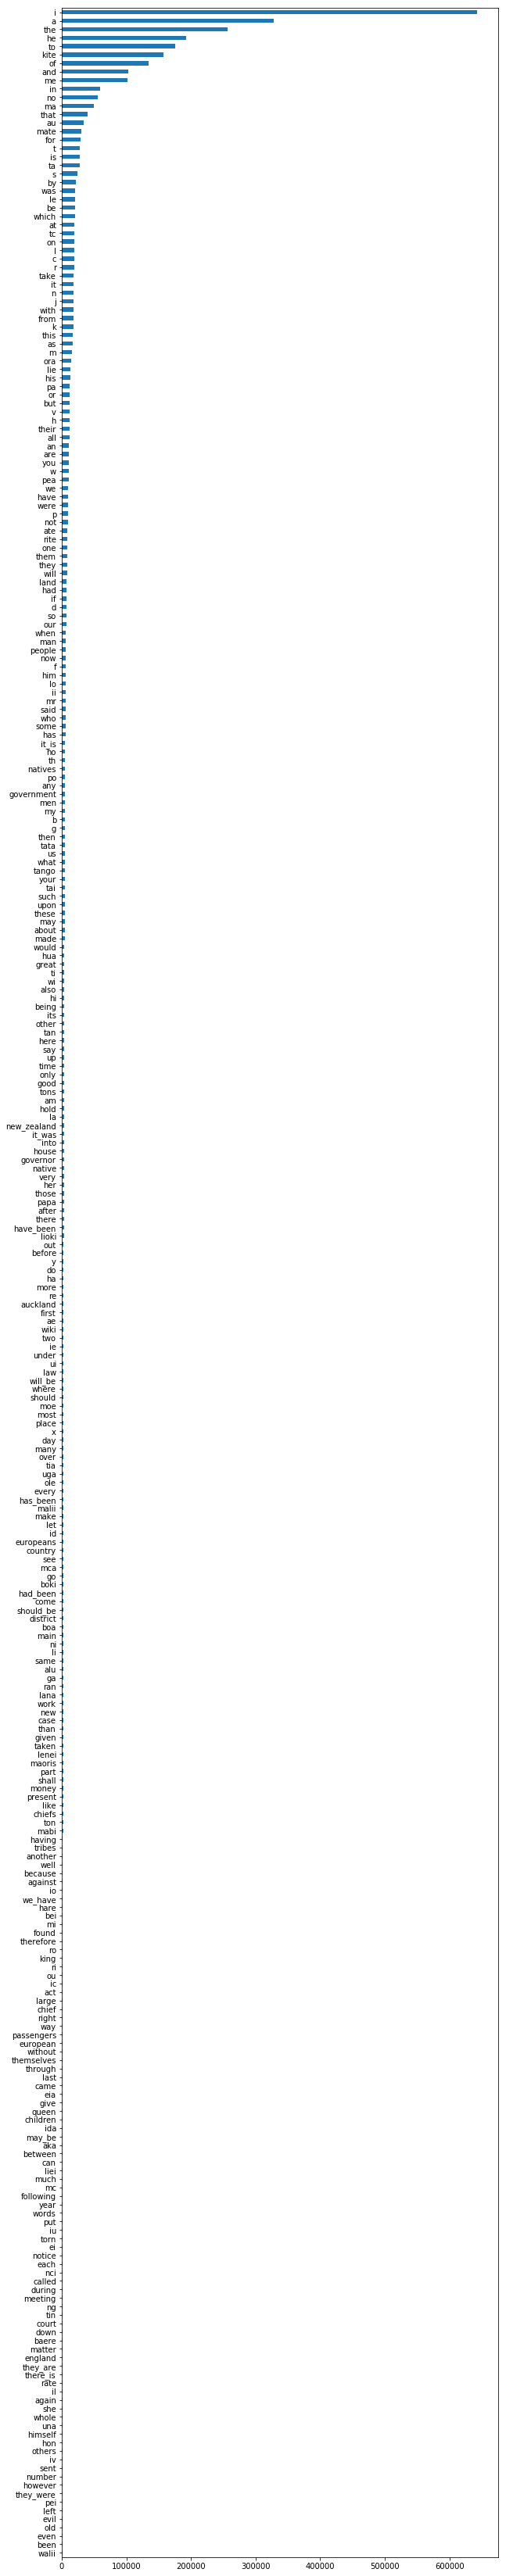

In [35]:
(pd.Series([w for l in papers['discarded'] for w in l.split()])
    .value_counts(ascending = True)
    .tail(300)
    .plot(kind = 'barh', figsize = (10, 60))
)

In [21]:
%%time
papers['phrase'] = phrase_model(
    (papers.words
        .apply(lambda x: ' '.join(
            [y for y in x if y in maori_words]
        ))),
    min_count = 30,
    threshold = 10,
    phrase_length = 5
)

CPU times: user 5min 2s, sys: 69.5 ms, total: 5min 2s
Wall time: 5min 2s


In [22]:
%%time
phrase_counts = papers.phrase.apply(str.split).explode().value_counts().to_frame().reset_index()
phrase_counts.columns = ['word', 'count']
phrase_counts

CPU times: user 7.14 s, sys: 485 µs, total: 7.14 s
Wall time: 7.13 s


,word,count
0,te,763785
1,e,388836
2,nga,356423
3,o,355744
4,ki,259854
...,...,...
124091,whootu,1
124092,paraweru,1
124093,mekereruka,1
124094,rikitiaa,1


## Train fasttext model

In [23]:
corpus_file = '../data/papers_corpus.txt'

In [24]:
with open(corpus_file, 'w') as f:
    for line in papers.loc[papers.phrase.str.len() != 0, 'phrase']:
        f.write(line + '\n')

In [25]:
%%time
model = fasttext.train_unsupervised(corpus_file, minCount = 30)

CPU times: user 5min 48s, sys: 506 ms, total: 5min 48s
Wall time: 24.5 s


In [26]:
model.save_model("../data/fasttext.bin")

In [27]:
model_data = pd.DataFrame({'word': model.words})
model_data = model_data[model_data.word != '</s>']
model_data['word_vector'] = model_data.word.apply(model.get_word_vector)
model_data

,word,word_vector
0,te,"[-0.21777533, 0.17077176, 0.026621312, 0.01177..."
2,e,"[-0.014604137, 0.016253103, -0.047741067, -0.0..."
3,nga,"[-0.10680067, 0.1927893, 0.13625881, 0.0888566..."
4,o,"[-0.039921887, 0.2784031, 0.10443064, 0.009199..."
5,ki,"[-0.1450836, 0.14730456, 0.007684499, -0.01274..."
...,...,...
7384,mahii,"[-0.08255132, 0.08159846, -0.031724125, 0.0027..."
7385,raoana,"[0.0014637297, 0.07997082, -0.06871581, -0.322..."
7386,tangira,"[0.28281572, -0.006056708, -0.08458752, -0.269..."
7387,rakaipaka,"[0.035745796, 0.20520549, 0.13017206, -0.10744..."


In [28]:
model_data = model_data.merge(phrase_counts, how = 'left', on = ['word'])

In [29]:
word_vectors = np.vstack(model_data.word_vector.apply(lambda x: x / norm(x)))

In [30]:
similarity_matrix = np.dot(word_vectors, word_vectors.transpose())

In [31]:
model_data['neighbours'] = (model_data
    .word
    .apply(lambda x: [(round(score, 2), model.get_word_id(word)) for score, word in model.get_nearest_neighbors(x)]))

In [67]:
model_data[['word', 'count']].to_csv('../data/model_data.csv', index = False)

In [32]:
model_data

,word,word_vector,count,neighbours
0,te,"[-0.21777533, 0.17077176, 0.026621312, 0.01177...",763785,"[(0.77, 4), (0.73, 3), (0.72, 1), (0.7, 63), (..."
1,e,"[-0.014604137, 0.016253103, -0.047741067, -0.0...",388836,"[(0.79, 8), (0.78, 9), (0.72, 47), (0.69, 23),..."
2,nga,"[-0.10680067, 0.1927893, 0.13625881, 0.0888566...",356423,"[(0.74, 4), (0.73, 0), (0.66, 66), (0.65, 8), ..."
3,o,"[-0.039921887, 0.2784031, 0.10443064, 0.009199...",355744,"[(0.77, 0), (0.74, 3), (0.73, 1), (0.71, 5), (..."
4,ki,"[-0.1450836, 0.14730456, 0.007684499, -0.01274...",259854,"[(0.72, 12), (0.71, 23), (0.71, 4), (0.71, 11)..."
...,...,...,...,...
7383,mahii,"[-0.08255132, 0.08159846, -0.031724125, 0.0027...",30,"[(0.7, 29), (0.7, 7303), (0.66, 181), (0.59, 1..."
7384,raoana,"[0.0014637297, 0.07997082, -0.06871581, -0.322...",30,"[(0.77, 3322), (0.74, 212), (0.69, 2985), (0.6..."
7385,tangira,"[0.28281572, -0.006056708, -0.08458752, -0.269...",30,"[(0.75, 3003), (0.67, 6773), (0.63, 4393), (0...."
7386,rakaipaka,"[0.035745796, 0.20520549, 0.13017206, -0.10744...",30,"[(0.87, 6108), (0.8, 3280), (0.77, 4829), (0.7..."


In [33]:
model_data['word_id'] = model_data.word.apply(model.get_word_id)

## Dimensionality reduction with UMAP

In [34]:
def calculate_umap(params, umap_data, similarity_matrix):
    neighbors, dist = params

    reducer = UMAP(n_neighbors = neighbors, min_dist = dist)
    reduced = reducer.fit_transform(similarity_matrix)

    umap_data['n_neighbors'] = neighbors
    umap_data['min_dist'] = dist
    
    umap_data['x'] = reduced[:, 0]
    umap_data['y'] = reduced[:, 1]

    umap_data = umap_data[['n_neighbors', 'min_dist', 'word', 'count', 'x', 'y']]

    umap_data['rank'] = np.arange(len(umap_data))

    umap_data = umap_data[umap_data.word != '</s>']

    umap_data.columns = ['n_neighbors', 'min_dist', 'word', 'word_count', 'x_coord', 'y_coord', 'rank']

    return umap_data

In [35]:
%%time
n_neighbours = [2, 5, 10, 20]
min_dist = [0.6, 0.8, 0.95, 0.99]

umap_results = pd.concat(
    multicore_apply(
        product(n_neighbours, min_dist), 
        partial(calculate_umap, 
                umap_data = model_data,
                similarity_matrix = similarity_matrix))
)

  0%|          | 0.00/16.0 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
  6%|▋         | 1.00/16.0 [00:53<13:20, 53.4s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
 12%|█▎        | 2.00/16.0 [00:53<08:43, 37.4s/it]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: Sett

CPU times: user 4.24 s, sys: 5.7 s, total: 9.94 s
Wall time: 1min 21s


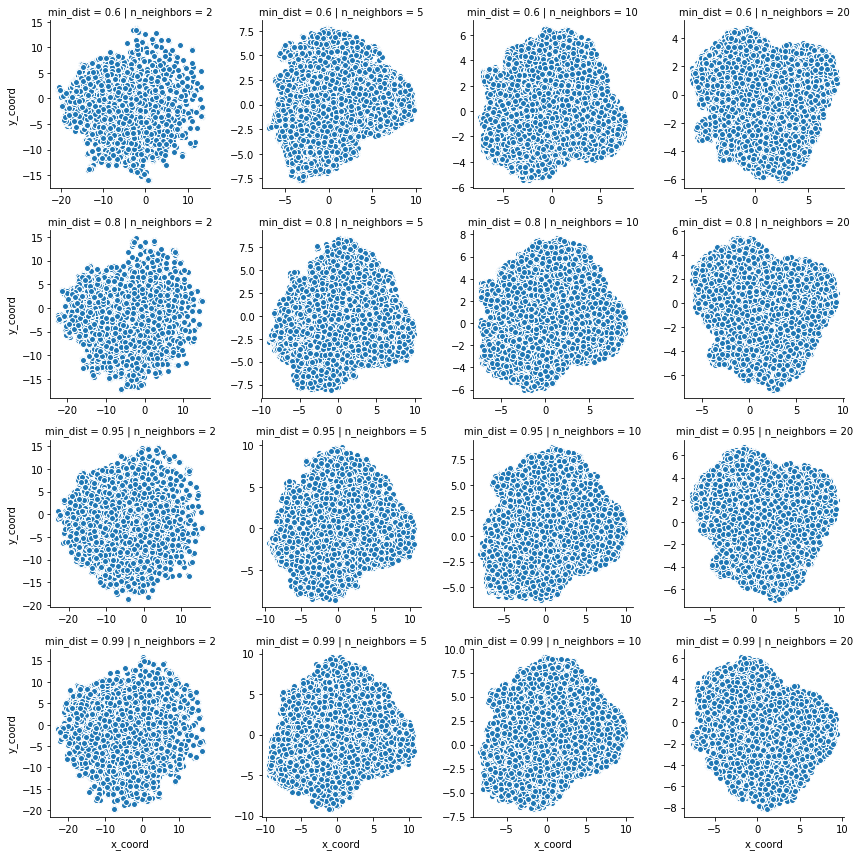

In [36]:
g = (sns.FacetGrid(umap_results, col="n_neighbors", row="min_dist", sharex = False, sharey = False)
    .map(plt.scatter, "x_coord", "y_coord", edgecolor="w")
)

In [37]:
umap_results['x_coord'] = umap_results.x_coord
umap_results['y_coord'] = -umap_results.y_coord

In [38]:
(umap_results
     .loc[
        (umap_results.n_neighbors == 10) & \
        (umap_results.min_dist == 0.8) & \
        ((umap_results.word_count > 30) |
        (umap_results.word.str.contains("_"))),
        ['word', 'word_count', 'x_coord', 'y_coord', 'rank']
     ].reset_index(drop = True)
      .to_csv('../data/umap.csv', index = False)
)

In [39]:
! mv ../data/umap.csv ../D3/newspapers/umap.csv

## Topic model

In [40]:
sentences = (papers
     .groupby(['newspaper_id', 'year', 'month', 'day', 'id', 'paragraph', 'sentence'])
     .agg({'phrase': lambda x: ' '.join(x).strip()})
     .reset_index()
)
sentences = sentences[sentences.phrase.str.len() > 0]
sentences

,newspaper_id,year,month,day,id,paragraph,sentence,phrase
3,AMW,1848,04,25,2.1,"STttttauam non paratu*,","STttttauam non paratu*,",paratu
4,AMW,1848,04,25,2.1,THE ANGLO-MAORI WARDER.,THE ANGLO-MAORI WARDER.,maori
18,AMW,1848,04,25,2.10,""" Chesham-place, Dec. 8, 1847. 4< My Lords, —I...",RepUß Professor of Divinity.,repu
22,AMW,1848,04,25,2.10,""" Chesham-place, Dec. 8, 1847. 4< My Lords, —I...",should virtually assent to the doctrine that a...,e
27,AMW,1848,04,25,2.10,Protest of the Bishops. The following importan...,"Bath AM/Wr.Lw *' J. H. Glocbstbr and Bristol ""...",e
...,...,...,...,...,...,...,...,...
796406,WHETU,1858,09,01,2.7,TE I. Tau ana te manaakitanga kite tangata Kao...,E pera ia rue te rakau whakato Kite parenga o ...,e pera ia te rakau whakato parenga o nga awa w...
796407,WHETU,1858,09,01,2.7,TE I. Tau ana te manaakitanga kite tangata Kao...,"Ko te hunga kino ia, ekore e penei, E rite ana...",ko te hunga kino ia ekore e penei e ana papapa...
796408,WHETU,1858,09,01,2.7,TE I. Tau ana te manaakitanga kite tangata Kao...,"Otira, ko tana whakaahuarekatanga Kei te ture ...",otira ko tana whakaahuarekatanga kei te ture i...
796409,WHETU,1858,09,01,2.7,TE I. Tau ana te manaakitanga kite tangata Kao...,TE I. Tau ana te manaakitanga kite tangata Kao...,te tau ana te manaakitanga tangata kaore e hae...


In [41]:
paragraphs = (papers
     .groupby(['newspaper_id', 'year', 'month', 'day', 'id', 'paragraph'])
     .agg({'phrase': lambda x: ' '.join(x).strip()})
     .reset_index()
)
paragraphs = paragraphs[paragraphs.phrase.str.len() > 0]
paragraphs

,newspaper_id,year,month,day,id,paragraph,phrase
2,AMW,1848,04,25,2.1,"STttttauam non paratu*,",paratu
3,AMW,1848,04,25,2.1,THE ANGLO-MAORI WARDER.,maori
5,AMW,1848,04,25,2.10,""" Chesham-place, Dec. 8, 1847. 4< My Lords, —I...",repu e
7,AMW,1848,04,25,2.10,Protest of the Bishops. The following importan...,e
9,AMW,1848,04,25,2.12,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.,ko te kai whakamataara o nga iwi erua
...,...,...,...,...,...,...,...
92913,WHETU,1858,09,01,2.6,UPOKO IV. I te tau o te Ariki 67 ka hapainga m...,upoko te tau o te ariki ka hapainga mai te tau...
92914,WHETU,1858,09,01,2.6,nga he ki nga Hurai kihai nei i whakapono kiat...,nga ki nga hurai kihai nei whakapono kiate kar...
92915,WHETU,1858,09,01,2.6,"otira, kihai a Hiha i whakaae kia noho ratou k...",otira kihai hiha whakaae kia noho ratou ki te ...
92916,WHETU,1858,09,01,2.7,TE I. Tau ana te manaakitanga kite tangata Kao...,te tau ana te manaakitanga tangata kaore e hae...


In [42]:
from scipy.linalg import norm

In [43]:
paragraphs['word_vector'] = paragraphs.phrase.apply(model.get_word_vector).apply(lambda x: x / norm(x))

In [44]:
paragraph_matrix = np.vstack(paragraphs.word_vector)

In [45]:
reducer = UMAP(n_components = 5, n_neighbors = 10, min_dist = 0.8)
reduced = reducer.fit_transform(paragraph_matrix)

In [46]:
reduced.shape

(84561, 5)

In [47]:
from sklearn.cluster import DBSCAN

In [48]:
clusters = DBSCAN(metric='cosine', eps=0.001, min_samples=50).fit_predict(reduced)

num_clusters = len(np.unique(clusters))
print("{} clusters identified".format(num_clusters))

paragraphs['cluster'] = clusters
cluster_data = paragraphs.groupby('cluster').agg({'phrase': lambda s: ' '.join(s).strip()}).reset_index()
cluster_data.phrase

70 clusters identified


0     paratu repu     e ko te kai whakamataara o nga...
1     maori maori maori maori maori maori maori maor...
2     maori  ia maori     ue   u e e uo oau maori   ...
3     o o o o o o o o o o o o o o o o o o o o o o o ...
4     te te   rone    tinge tare    ihe             ...
                            ...                        
65    wharangi_tuwhera nga hoa tuhi mai wharangi_tuw...
66    wharangi_tuwhera wharangi_tuwhera wharangi_tuw...
67    whakataua ana ko te ingoa te pukapuka o te pee...
68    uro te wananga te wananga te wananga te wanang...
69    tihe_mauri tihe_mauri tihe_mauri tihe_mauri ti...
Name: phrase, Length: 70, dtype: object

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
tfidf = TfidfVectorizer()

In [51]:
X = tfidf.fit_transform(cluster_data.phrase)

In [52]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(X.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]

In [53]:
X = X.toarray()

In [54]:
feature_names = tfidf.get_feature_names()

In [55]:
np.sum(X > 0, axis = 1)

array([123832,      2,     63,      5,     14,      4,      3,    597,
           13,    234,      1,     34,      1,      1,    251,     14,
            9,      7,      1,     79,      6,    458,      3,      9,
            8,      1,      1,      1,      7,      3,      3,      1,
           25,      1,     12,     18,     42,     20,      6,      3,
            9,     11,     29,     62,     15,     22,     71,      4,
            1,     56,     22,      9,    172,      1,      9,     10,
            4,     13,     10,    211,      6,    114,     68,      8,
            2,      9,      1,   1384,     17,      2])

In [56]:
[m for m in dir(model) if not m.startswith('_')]

['bucket',
 'dim',
 'epoch',
 'f',
 'get_analogies',
 'get_dimension',
 'get_input_matrix',
 'get_input_vector',
 'get_label_id',
 'get_labels',
 'get_line',
 'get_meter',
 'get_nearest_neighbors',
 'get_output_matrix',
 'get_sentence_vector',
 'get_subword_id',
 'get_subwords',
 'get_word_id',
 'get_word_vector',
 'get_words',
 'is_quantized',
 'label',
 'labels',
 'loss',
 'lr',
 'lrUpdateRate',
 'maxn',
 'minCount',
 'minCountLabel',
 'minn',
 'neg',
 'predict',
 'pretrainedVectors',
 'quantize',
 'save_model',
 'set_args',
 'set_matrices',
 't',
 'test',
 'test_label',
 'thread',
 'verbose',
 'wordNgrams',
 'words',
 'ws']

In [57]:
model.get_analogies('patuone', 'maori', 'kawana_kerei')

[(0.6438210010528564, 'tamati_waka_nene'),
 (0.5928552746772766, 'waka_nene'),
 (0.5862451791763306, 'tamati_hapimana'),
 (0.58620685338974, 'pororua'),
 (0.5745435953140259, 'honana'),
 (0.5729209184646606, 'maioha'),
 (0.572145938873291, 'matutaera'),
 (0.5650669932365417, 'tamati_ngapora'),
 (0.5620673298835754, 'arama_karaka'),
 (0.5583099126815796, 'hamahona')]

In [58]:
def get_analogies(termA, termB, termC, k=15):
    return (pd.DataFrame(
        model.get_analogies(termA, termB, termC, k=k), 
        columns = ['similarity', 'term'])
       .sort_values('similarity')
       .plot(kind = 'barh', x = 'term', y = 'similarity', title = '{} is to {} as {} is to:'.format(termA, termB, termC))
    )


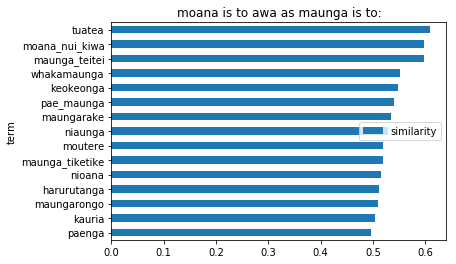

In [59]:
get_analogies('moana', 'awa', 'maunga')

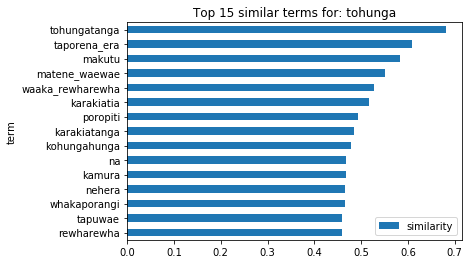

In [60]:
def get_similar_terms(term, k = 15):
    return (pd.DataFrame(
        model.get_nearest_neighbors(term, k=k), 
        columns = ['similarity', 'term'])
       .sort_values('similarity')
       .plot(kind = 'barh', x = 'term', y = 'similarity', title = 'Top {} similar terms for: {}'.format(k, term))
    )
    
get_similar_terms('tohunga')

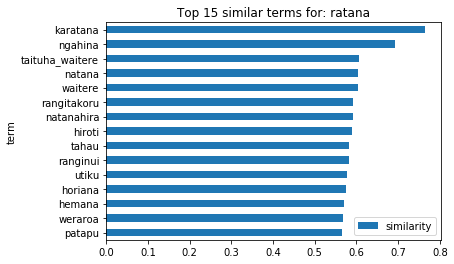

In [61]:
get_similar_terms('ratana')

In [62]:
num_top_words = 5
top_words = []
for i in range(num_clusters):
    tfidf_counts = X[i,:]
    sort_indices = np.argsort(-tfidf_counts)
    top_words.append([feature_names[idx] for idx in sort_indices[:num_top_words]])

In [63]:
print('\n\n'.join([' '.join(s) for s in top_words]))

te nga ki ka ana

maori aite rironi rirongo rirongii

maori kiwi ia iho uhi

ki mai rote roto ote

te mete iutere iore tinge

ana kia kaua ina rirooea

maori aii hie rirooea riroo

maori waka pakeha te ihe

ko te aeoha pono tika

ka te ki mai nga

ihe aae riroo rironi rirongo

maori ko hoa te ia

taranaki aae riroo rironi rirongo

waikato aae riroo rironi rirongo

utu mote ka atu pauna

mauri mahi uu ooa towu

aotearoa te paunui aoteaeoa tearoa

pukapuka hoko ukapuka kapuka whare

akarana rirooea riroo rironi rirongo

powhiri te wehi ana ki

upoko upoki ika takiwa mau

te nui_tireni ko karere nga

panuitanga uitanga anuitanga aae rirooea

huia kotahi tangata aitua mano

tukua reta mai tekua ke

tangata aae rirongo rirongii rirongi

heretaunga aae rirooea riroo rironi

nama aae riroo rironi rirongo

rongo korero nga taina kingi

tupapaku tanumanga nehunga aae rironi

maehe tokio ra riroraua rirooea

panui aae riroo rironi rirongo

pitopito_korero pitopito nga te horero

whanganui aae ri